# Function definitions

In [1]:
# Import libraries
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib import gridspec
import plotly.express as px
import pandas as pd 
import numpy as np
import datetime 
import imageio
import os
pd.set_option('display.max_colwidth', None)

In [2]:
# Definition of the topic's weight in each group
def averageTopicInterest(data, topic, group):
    """
    Calculate the average topic interest in a given group.

    Args:
        data (DataFrame): The input data containing topic and partisan information.
        topic (str): The name of the topic column. We work with 10 topics, so topic takes values between 0 to 9
        group (str): The name of the group column. It can be FF or MP (Center-Left of Center-Right leaning)

    Returns:
        float: The weighted average of the topic's interest in the group.
    """
    return np.average(data[f'T{topic}'], weights=data[f'#{group}'])


def groupByOutlet(df_m):
    """
    Group the data by the outlet media and calculate differences in percentages.

    Args:
        df_m (DataFrame): The input DataFrame with data grouped by outlet.

    Returns:
        DataFrame: The grouped data with a 'difference' column, sorted by the difference in descending order.
    """
    # Group the data by outlet
    data_grouped_by_outlet = df_m.groupby('outlet').sum()

    # Rename columns for consistency
    if 'FF' in data_grouped_by_outlet.columns:
        data_grouped_by_outlet = data_grouped_by_outlet.rename(columns={'FF': '#FF'})
    if 'MP' in data_grouped_by_outlet.columns:
        data_grouped_by_outlet = data_grouped_by_outlet.rename(columns={'MP': '#MP'})

    # Calculate the difference between percentages to sort the data
    difference = (data_grouped_by_outlet['#FF'] / data_grouped_by_outlet['#FF'].sum()) - (data_grouped_by_outlet['#MP'] / data_grouped_by_outlet['#MP'].sum())

    # Add the 'difference' column and sort the data
    data_grouped_by_outlet['difference'] = difference
    data_grouped_by_outlet.sort_values(by='difference', inplace=True, ascending=False)

    return data_grouped_by_outlet

    
# Define the SB (Sentiment Bias) of a news article x. If there are no mentions of a candidate, SB is undefined.
def SB_Albanese2020(x):
    """
    Calculate the Sentiment Bias (SB) of a news item.

    Args:
        x (Series): A row (news item) from the input data with sentiment-related columns.

    Returns:
        float or NaN: The calculated SB if there are mentions, or NaN if no mentions are present.
    """
    ans = (x['pos_CR'] - x['neg_CR']) - (x['pos_CL'] - x['neg_CL']) 
    norm = x['N_CL'] + x['N_CR']
    if norm != 0:
        return ans / norm
    else:
        return np.nan
    
def one_hot_encode(df, col='opinion'):
    """
    Encode a categorical column into one-hot columns with 1s and 0s.

    Args:
        df (DataFrame): The input DataFrame.
        col (str): The name of the column to be one-hot encoded.

    Returns:
        DataFrame: The input DataFrame with one-hot encoded columns.
    """
    one_hot = pd.get_dummies(df[str(col)])
    df = df.join(one_hot)
    return df

def add_accents(x):
    """
    Add accents to specific words in the input string.

    Args:
        x (str): The input string to add accents to.

    Returns:
        str: The input string with added accents.
    """
    x = x.replace('Pagina 12', 'Página 12').replace('Clarin', 'Clarín').replace('La Nacion', 'La Nación').replace('El Dia', 'El Día')
    return x

def index_sorted_list(l):
    return sorted(range(len(l)), key=lambda k: l[k])

# Load data

In [3]:
df = pd.read_csv('data.csv')

In [4]:
# Group and count articles in the main DataFrame by 'outlet' and sort descending
dfg = df.groupby('outlet').count().sort_values(by='tid', ascending=False).reset_index()

# Define the main outlets as the first 6 that are most frequently shared:
print('dfg: \n', dfg[['outlet','tid']].rename(columns = {'tid':'# tweets'}).head(6))
main_outlets = dfg['outlet'][0:6].to_list()

dfg: 
           outlet  # tweets
0     El Destape    307021
1         Clarin    160226
2        Infobae    141902
3      La Nacion    104183
4  Todo Noticias     95286
5      Pagina 12     76274


# Calculate Sentiment Bias (SB)

## SB by news articles

Calculate the sentiment bias (SB) of the news articles

In [5]:
df['SB'] = df.apply(lambda row: SB_Albanese2020(row), axis = 1)

Dinamic model of votting: We choose the intention of votting as the label for each tweet

In [6]:
df_dynamic = df[df['dynamic_opinion'].isin(['FF','MP'])].copy()
df_dynamic = one_hot_encode(df_dynamic,col = 'dynamic_opinion')
df_dynamic[['url','FF','MP']].head()

,url,FF,MP
97,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,0,1
99,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,0,1
101,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,0,1
109,https://www.eldestapeweb.com/c56796,1,0
184,https://www.eldestapeweb.com/c56731,1,0


Grouping data by media

In [7]:
data_aggregated_by_outlet = groupByOutlet(df_dynamic)
data_aggregated_by_outlet.head()

,age,tid,uid,pos_CL,neg_CL,N_CL,pos_CR,N_CR,neg_CR,T0,...,T7,T8,T9,month,week,day,SB,#FF,#MP,difference
outlet,,,,,,,,,,,,,,,,,,,,,
El Destape,1046120.0,2.709063e+22,5.125353e+21,1685.0,5747.0,26318.0,476.0,34906.0,12521.0,1331.517951,...,2400.254869,577.894943,3218.462743,155361.0,634789.0,367397.0,-2596.116117,23007.0,623.0,0.333779
Pagina 12,462076.0,1.103623e+22,1.543034e+21,993.0,4559.0,17036.0,513.0,23962.0,11355.0,609.807014,...,825.704434,168.770470,1529.875082,62903.0,256956.0,151526.0,-1408.452766,9166.0,464.0,0.127620
Minuto Uno,156936.0,4.177967e+21,7.065984e+20,966.0,1657.0,8187.0,238.0,11715.0,5467.0,199.921802,...,275.415164,78.992316,475.750484,23227.0,94697.0,56297.0,-641.688425,3399.0,253.0,0.045315
Ambito Financiero,214679.0,5.421664e+21,8.006479e+20,584.0,3381.0,12503.0,561.0,14649.0,5820.0,199.623741,...,424.790270,63.615754,329.682467,31097.0,127252.0,73780.0,-456.259961,3442.0,1287.0,0.020296
La Izquierda Diario,63773.0,1.819102e+21,2.113712e+20,58.0,870.0,3005.0,32.0,2510.0,1050.0,64.898186,...,205.412370,31.915400,389.031346,9524.0,38716.0,25131.0,-124.396739,1374.0,222.0,0.015346


In [8]:
'''
# News articles with Sentiment Bias defined data
dfsb = df[['url','outlet','SB']].drop_duplicates()
dfsb = dfsb.dropna(subset = ['SB'])
dfsb.head()
'''

"\n# News articles with Sentiment Bias defined data\ndfsb = df[['url','outlet','SB']].drop_duplicates()\ndfsb = dfsb.dropna(subset = ['SB'])\ndfsb.head()\n"

## Mean SB by media outlet

We drop the news duplicated

In [9]:
data = df.copy()
data.drop_duplicates('url', inplace=True)

### Calculate SB

Then we calculate the mean sentiment bias of each outlet media

In [10]:
sb_by_outlet = data.groupby('outlet').mean()['SB'].copy()
# Las ordenamos de SB positivo a negativo
sb_by_outlet.sort_values(inplace = True, ascending = False)
sb_by_outlet

outlet
Radio Mitre            0.018723
La Nacion              0.017314
Clarin                 0.013843
Todo Noticias          0.011042
Infobae               -0.005873
El Litoral            -0.007791
El Dia                -0.016239
Radio Dos             -0.024567
Perfil                -0.026037
El Cronista           -0.035990
Ambito Financiero     -0.053359
Contexto              -0.065660
Jornada               -0.070813
Minuto Uno            -0.132435
El Destape            -0.137041
La Izquierda Diario   -0.146203
Pagina 12             -0.177808
Name: SB, dtype: float64

In [11]:
# News articles with SB
data_with_sentiment = data.dropna(subset = ['SB'])

### Calculate  SB Error 

Bootstraping to Calculate SB Error by Outlet

In [12]:
# Create a list of unique outlets from the 'sb_by_outlet' DataFrame
unique_ordered_outlets = sb_by_outlet.index

# Initialize an empty list to store quantiles of SB values
quantiles99 = []

# Iterate over each outlet
for outlet in unique_ordered_outlets:
    
    # Create a copy of the DataFrame containing sentiment data for the current outlet
    data_SB_outlet = data_with_sentiment[data_with_sentiment.outlet == outlet].copy()
    
    # Initialize an empty list to store SB values from bootstrap samples
    SB_bootst = []
    
    # Perform 1000 bootstrap iterations
    for iteration in range(1000):
        
        # Randomly sample from the data with replacement
        sample = data_SB_outlet.sample(n=data_SB_outlet.shape[0], replace=True)
        
        # Calculate the mean SB value for the sample and store it in the list
        SB_bootst.append(sample['SB'].mean())
    
    # Calculate and append the 0.5th and 99.5th quantiles of the SB values
    quantiles99.append(np.quantile(SB_bootst, q=[0.005, 0.995]))


Assigning Quantiles to Calculate Sesgo (Bias) by Outlet

In [13]:
# Create a DataFrame to store the data by outlet
sb_by_outlet = pd.DataFrame(sb_by_outlet)

# Reset the index of the DataFrame data_SB_outlet
sb_by_outlet.reset_index(inplace=True)

# Assign the 0.5th quantile values to the '1%' column
sb_by_outlet['1%'] = [q[0] for q in quantiles99]

# Assign the 99.5th quantile values to the '99%' column
sb_by_outlet['99%'] = [q[1] for q in quantiles99]

# Set the 'outlet' column as the index of data_SB_outlet
sb_by_outlet.set_index('outlet', inplace=True)
print('sb_by_outlet contains mean SB values for each outlet, along with their corresponding quantiles (1% and 99%).')
sb_by_outlet.head()

sb_by_outlet contains mean SB values for each outlet, along with their corresponding quantiles (1% and 99%).


,SB,1%,99%
outlet,,,
Radio Mitre,0.018723,-0.002486,0.040503
La Nacion,0.017314,0.003474,0.029123
Clarin,0.013843,0.002541,0.024765
Todo Noticias,0.011042,-0.009913,0.030664
Infobae,-0.005873,-0.018275,0.005869


# Calculate the difference of NS

In [19]:
indices_sb = sb_by_outlet.index
data_aggregated_by_outlet_indicessb = data_aggregated_by_outlet.reindex(index = indices_sb)
dfg_unicos_reindexsb = data_aggregated_by_outlet_indicessb.reindex(index = indices_sb)

In [20]:
# Calculate the difference of news sharing percentage by partisans
percent_MP = 100 * (data_aggregated_by_outlet_indicessb['#MP'] / data_aggregated_by_outlet_indicessb['#MP'].sum())
percent_FF = 100 * (data_aggregated_by_outlet_indicessb['#FF'] / data_aggregated_by_outlet_indicessb['#FF'].sum())
dif_percent = percent_MP - percent_FF 

In [21]:
# Order sb_by_oultlet by SB values
sb_by_outlet = sb_by_outlet.sort_values('SB')
sb_by_outlet

,SB,1%,99%
outlet,,,
Pagina 12,-0.177808,-0.195921,-0.158482
La Izquierda Diario,-0.146203,-0.180390,-0.113386
El Destape,-0.137041,-0.153203,-0.120894
Minuto Uno,-0.132435,-0.158595,-0.105473
Jornada,-0.070813,-0.115030,-0.023160
Contexto,-0.065660,-0.111167,-0.022106
Ambito Financiero,-0.053359,-0.073102,-0.033743
El Cronista,-0.035990,-0.054420,-0.017512
Perfil,-0.026037,-0.040738,-0.011208


# Plot mean SB by outlet

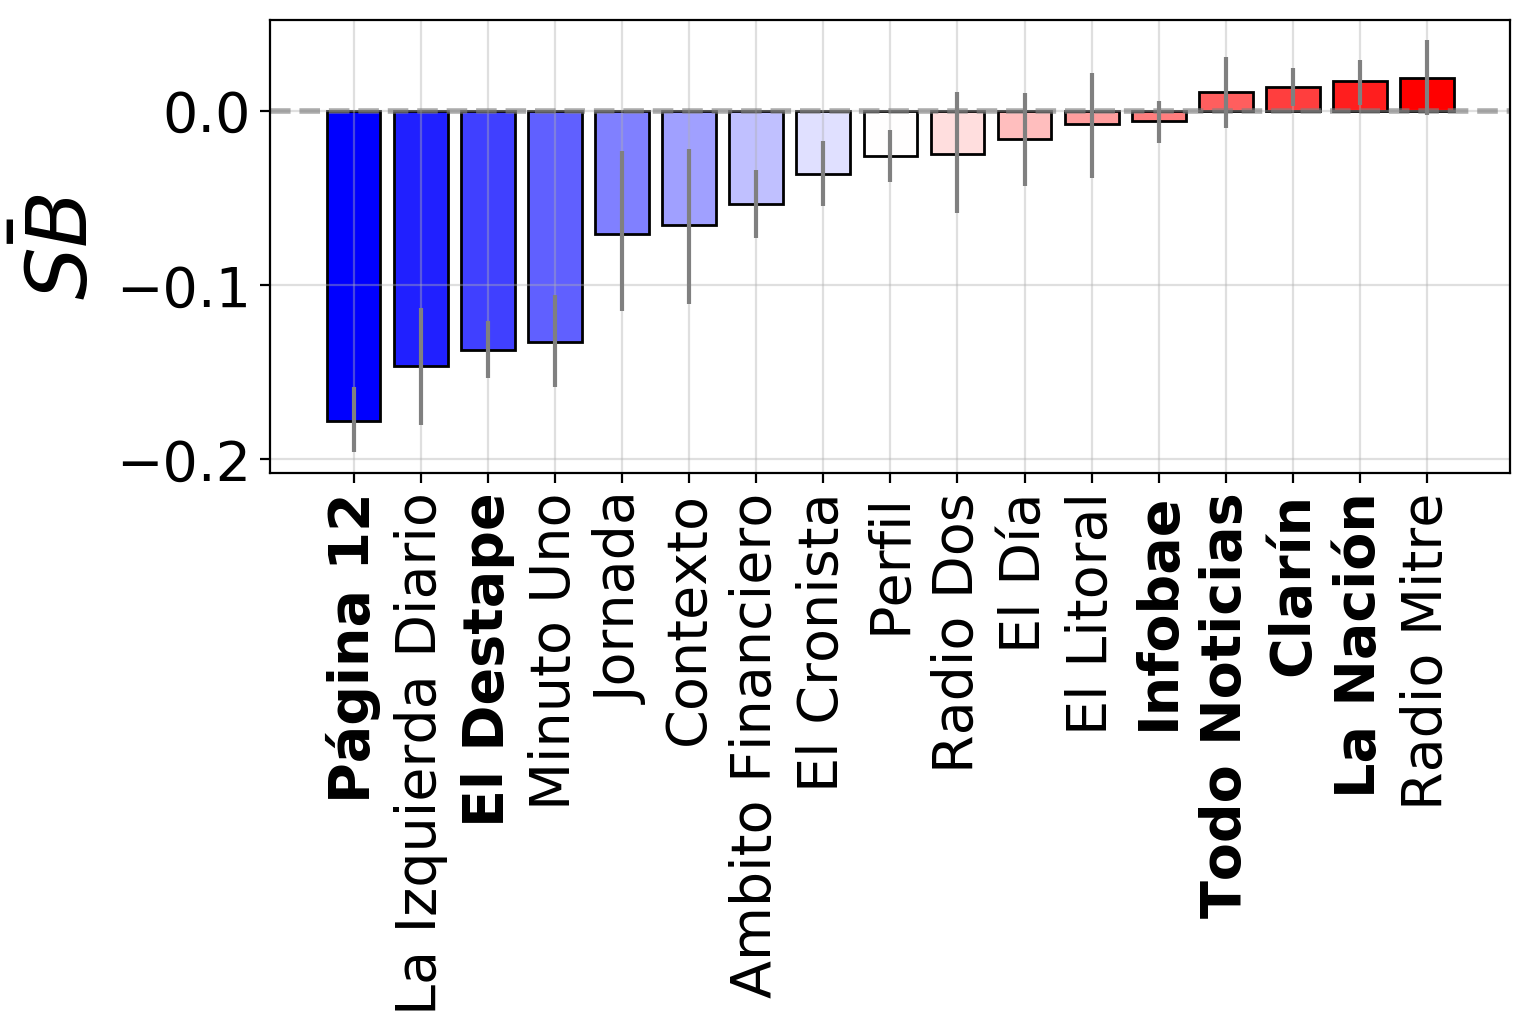

In [22]:
# Create the subplots
fig, ax1 = plt.subplots(figsize=(8,3),dpi = 200)
colors = plt.cm.bwr(np.linspace(0, 1, len(sb_by_outlet['SB'].to_list())))


for i in range(sb_by_outlet.shape[0]):
    ax1.vlines(x = i, ymin=sb_by_outlet['1%'].to_list()[i], ymax=sb_by_outlet['99%'].to_list()[i], color = 'grey')

ax1.bar(range(sb_by_outlet.shape[0]), sb_by_outlet['SB'].to_list(), label = r'$\bar{SB}$ by outlet',color = colors,linewidth=1,edgecolor='black')   
ax1.set_xticks(range(sb_by_outlet.shape[0]))
indicest = sb_by_outlet.index
indicest = [add_accents(i) for i in indicest]
ax1.set_xticklabels(indicest, rotation=90)
ax1.axhline(0, linestyle = '--', color = 'grey', linewidth = 2, alpha = 0.65, label = r'$\bar{SB}=0$')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_ylabel(r'$\bar{SB}$', size = 30)
ax1.grid(alpha = 0.4)

indices = list(sb_by_outlet.index)
bold_xticks = [indices.index(m) for m in indices if m in main_outlets]  # Index positions of the xticks to be bold
bold_font = FontProperties(weight='bold',size = 20)
for i, xtick in enumerate(ax1.get_xticklabels()):
    if i in bold_xticks:
        xtick.set_font_properties(bold_font)

plt.show()

# Plot news shared difference and mean SB

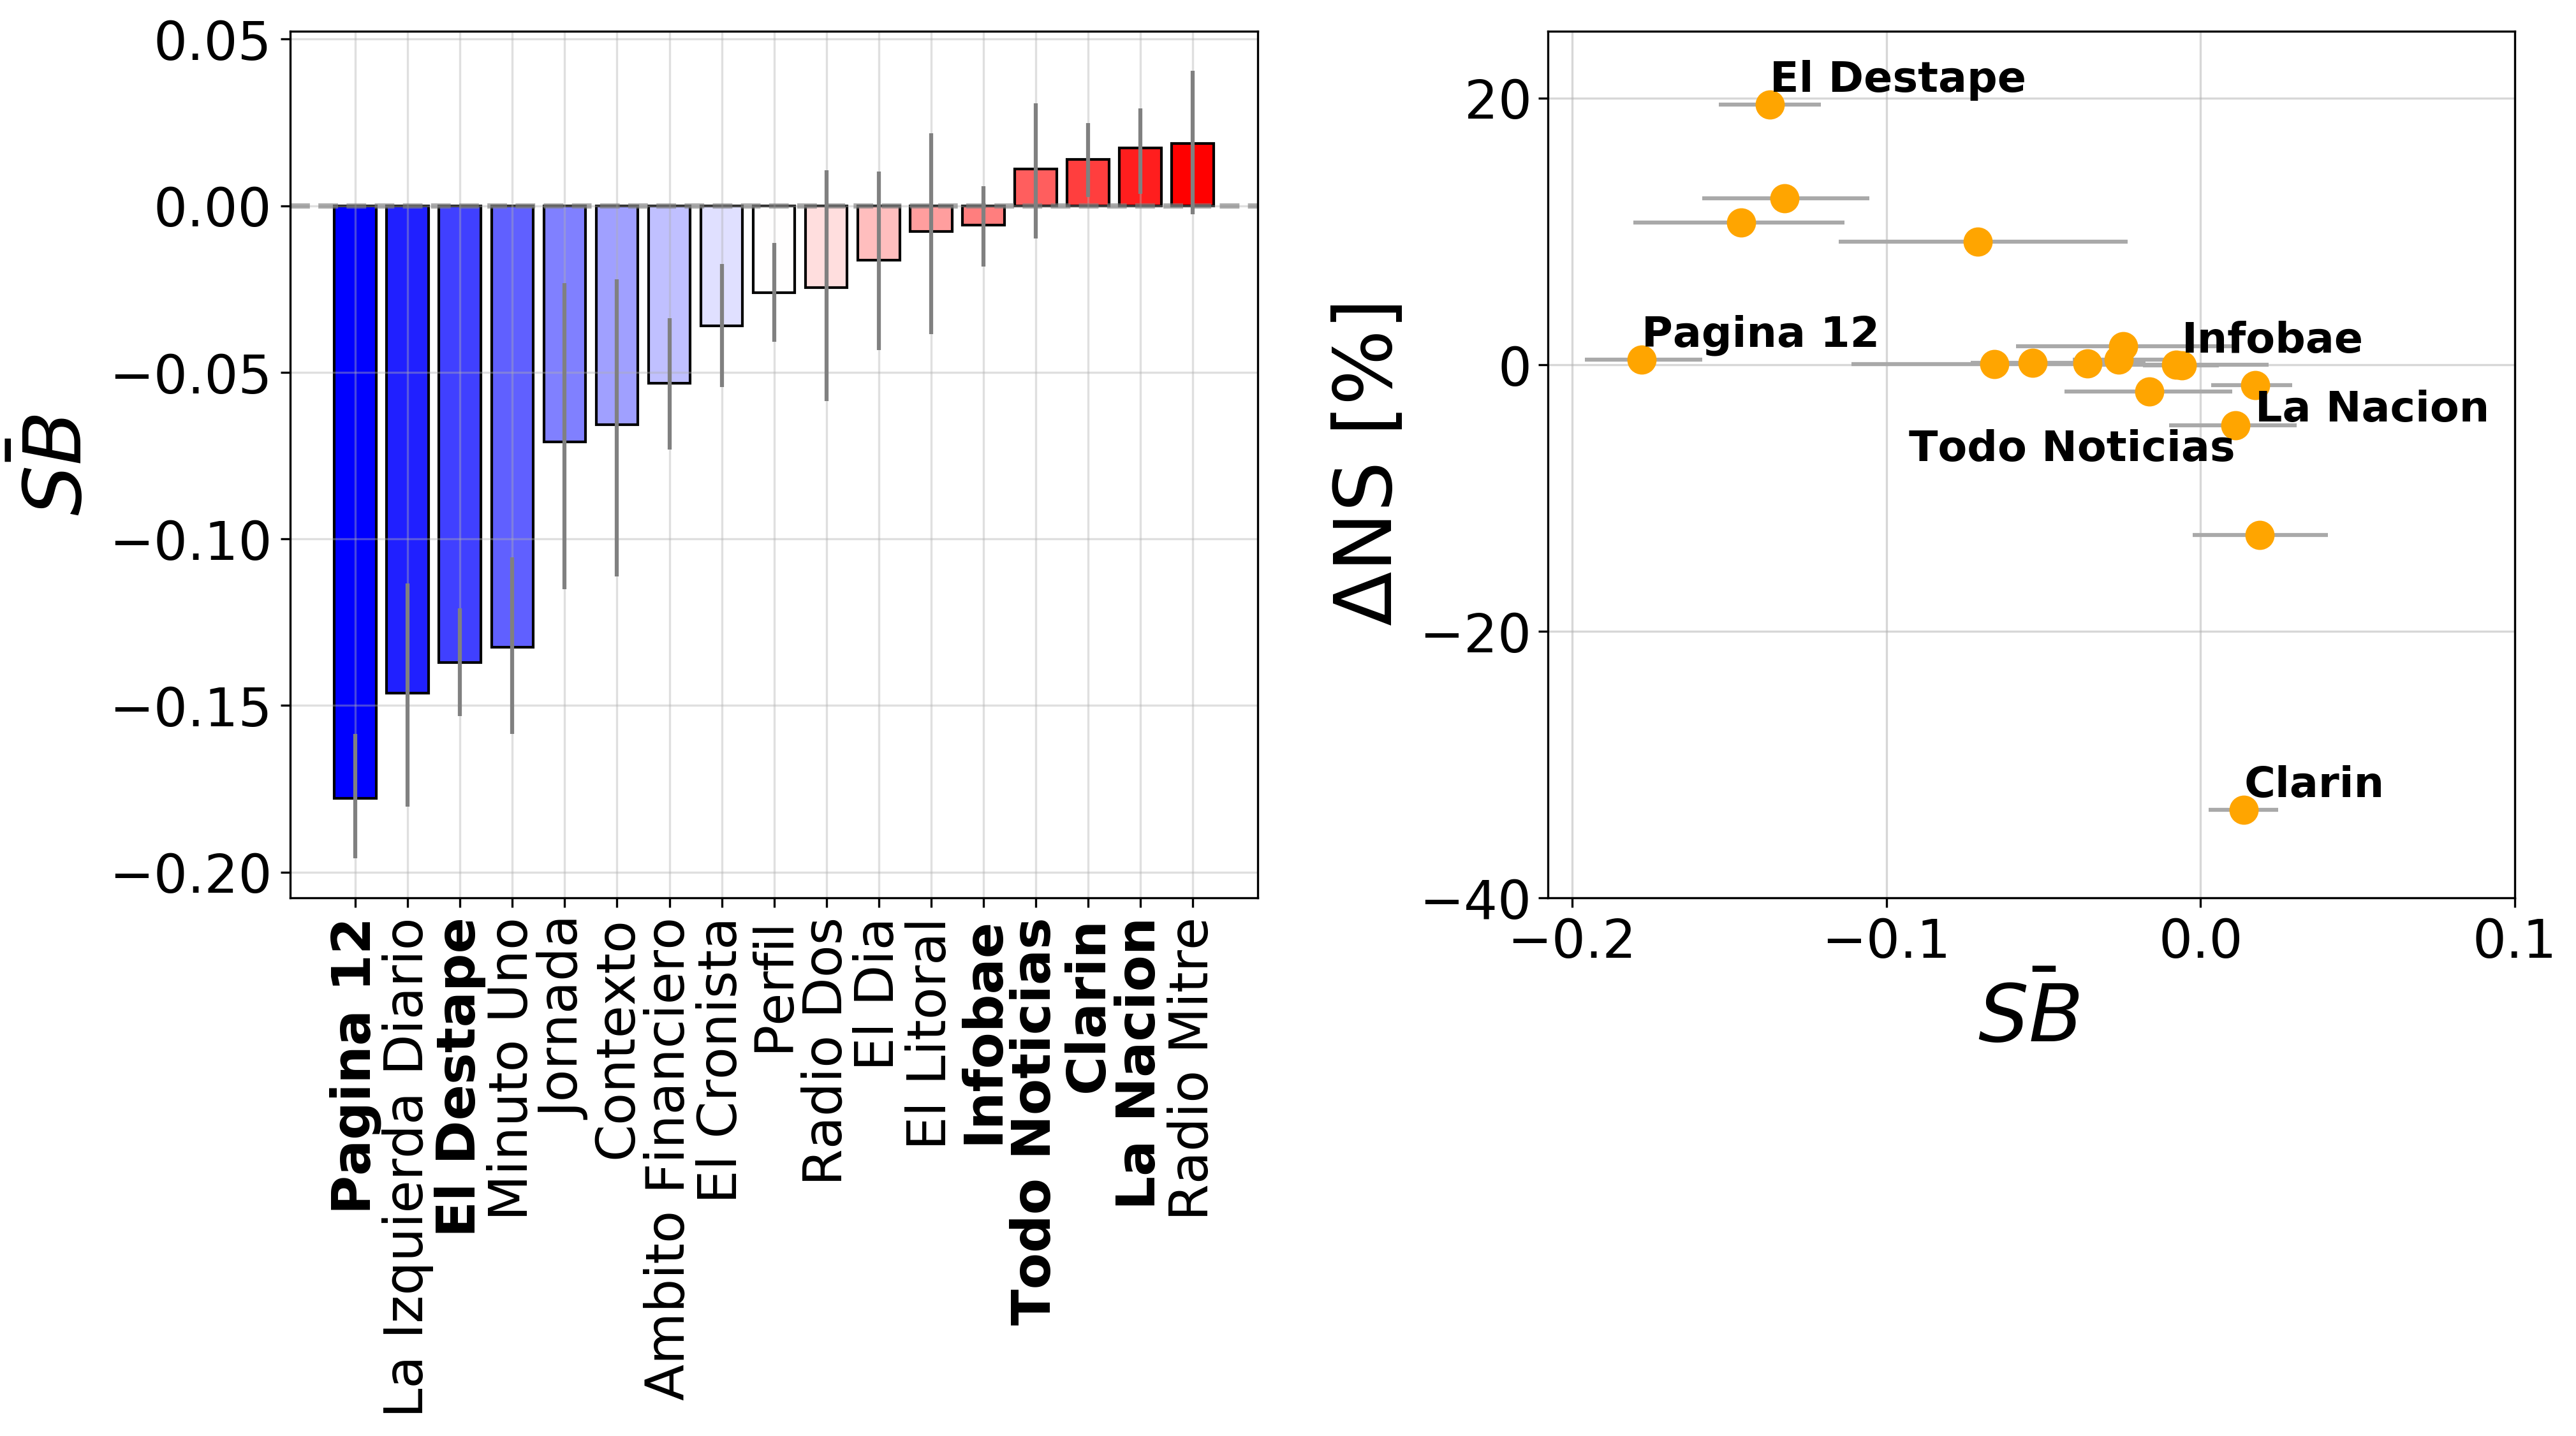

In [23]:
# Create the subplots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6),dpi = 300)

colores = plt.cm.bwr(np.linspace(0, 1, len(sb_by_outlet['SB'].to_list())))

for i in range(sb_by_outlet.shape[0]):
    ax1.vlines(x = i, ymin=sb_by_outlet['1%'].to_list()[i], ymax=sb_by_outlet['99%'].to_list()[i], color = 'grey')

ax1.bar(range(sb_by_outlet.shape[0]), sb_by_outlet['SB'].to_list(), label = r'$\bar{SB}$ by outlet',color = colores,linewidth=1,edgecolor='black')# color = ['maroon' if sesgo_por_mediof['SB'].to_list()[i] < 0.00 else 'black' for i in range(sesgo_por_mediof.shape[0])])
                
ax1.set_xticks(range(sb_by_outlet.shape[0]))
ax1.set_xticklabels(sb_by_outlet.index, rotation=90)
ax1.axhline(0, linestyle = '--', color = 'grey', linewidth = 2, alpha = 0.65, label = r'$\bar{SB}=0$')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_ylabel(r'$\bar{SB}$', size = 30)
ax1.grid(alpha = 0.4)

indices = list(sb_by_outlet.index)
bold_xticks = [indices.index(m) for m in indices if m in main_outlets]  # Index positions of the xticks to be bold
bold_font = FontProperties(weight='bold',size = 20)
for i, xtick in enumerate(ax1.get_xticklabels()):
    if i in bold_xticks:
        xtick.set_font_properties(bold_font)
        
for i in range(len(dif_percent)):
    ax2.hlines(xmin=sb_by_outlet['1%'].to_list()[i], xmax=sb_by_outlet['99%'].to_list()[i],y = dif_percent[i],  color = 'darkgray')
ax2.plot(sb_by_outlet['SB'].to_list(),dif_percent,'o',ms = 10,color = 'orange')#,label = r'$\Delta$NS = ${NS}_{CR}$ - ${NS}_{CL}$')
ax2.set_xlabel(r'$\bar{SB}$ ',fontsize = 30)
ax2.set_ylabel(r'$\Delta$NS [%]',fontsize = 30)
ax2.yaxis.get_offset_text().set_fontsize(14)  # Adjust the font size of the scientific notation
ax2.ticklabel_format(style="sci", axis="y", scilimits=(0,2), useMathText=True, useOffset=False) 
ax2.set_xticks([-0.2,-0.1,0,0.1])
ax2.set_yticks([-40,-20,0,20])
#ax2.set_xlim([-0.25,0.22])
ax2.set_ylim([-40,25])
ax2.grid(alpha = 0.5)
ax2.tick_params(axis='both', labelsize=20)
#ax2.legend(fontsize = 18)

index_by_dif = index_sorted_list(dif_percent)
texts = []
for x,y,t,i in zip(sb_by_outlet['SB'].to_list(),dif_percent,sb_by_outlet.index,index_by_dif):
    
    label = str(t)
    if label not in main_outlets:
        label = ''
    texts.append(plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,0), # distance from text to points (x,y)
                 ha='center',
                 fontsize = 16,
                 weight='bold'))

distances = [10,10,-12,7,10,-12,10,5]
plt.subplots_adjust(wspace=0.3)

adjust_text(texts, only_move={'points':'y', 'texts':'y'})

plt.show()

In [24]:
# Calculate Spearman correlation between mean Sentiment Bias and the difference 
from scipy import stats
correlation_result = stats.spearmanr(sb_by_outlet['SB'].to_list(),dif_percent)

# Print the correlation between delta NS and mean SB by media outlet
print("Spearman Correlation between delta NS and mean SB by media outlet:")
print("Correlation Coefficient:", correlation_result.correlation)
print("Two-tailed p-value:", correlation_result.pvalue)

Spearman Correlation between delta NS and mean SB by media outlet:
Correlation Coefficient: -0.8676470588235294
Two-tailed p-value: 6.426473554233676e-06
